# Model selection, TF-IDF and grabbing more than one feature

## Import all the necessary libraries

In [17]:
# -*- coding: UTF-8 -*-
import pandas as pd, numpy as np
import datetime
import re
import itertools
import matplotlib.pyplot as plt
import sys
'''default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr

sys.setdefaultencoding('UTF8')
'''
sys.path.insert(0, '../../TAOPYPY/')
import parser_data_cleaning as p
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
# En el caso de querer probar con un CountVectorizer, descomentar el TF-IDF y cambiar lineas.
# from sklearn.feature_extraction.text import CountVectorizer

my_stop_words = list(ENGLISH_STOP_WORDS)
my_stop_words.extend(['yes', 'won', 'way', 'trip', 'travel', 'think', 
                      'sent', 'said', 'says', 'right', 'new', 'need', 
                      'morning', 'make', 'line', 'like', 'let', 'lax', 
                      'jfk', 'http', 'got', 'getting', 'flightr', 'fly',
                      'flt', 'flights', 'flight', 'flighted', 'dfw', 'did', 'does', 'amp'])

## Functions

##### Get training and testing data

In [7]:
def obtain_data_representation(df, test=None, show_modelwords = False, show_modelparams = False):
    'A function to obtain a good data format to feed into our ML algorithms'
    # If there is no test data, split the input
    if test is None:
        # Divide data in train and test
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        # Otherwise, all is train. This is done for the case when we want to use the algorithm for prediction.
        # The function will prepare the data to be given to the model in the correct format
        train = df
        
    # Create 3 Bag of Words (BoW), by using train data only. 
    # We don't have the negativereason in the submission dataset, so we can't include it in our results!
    tfidf_1 = TfidfVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)
    cvec = CountVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)
    #tfidf_3 = TfidfVectorizer(max_features = 100, token_pattern = r'[A-Za-z]{3,}|no', strip_accents = 'unicode', stop_words = 'english', min_df = 0.1, max_df = 0.7)
    
    # We'll use 3 categories: the text of the tweet (main one), the name of the airline and the negativereason as well 
    x_train_1 = tfidf_1.fit_transform(train['text'])
    x_train_2 = cvec.fit_transform(train['text'])
    #x_train_3 = tfidf_3.fit_transform(train['negativereason'])
    y_train = train['airline_sentiment'].values
    
    # Con el countVectorizer:
    # cv = CountVectorizer(max_features=200, token_pattern = r'[A-Za-z]{3,}|no')
    # x_train = cv.fit_transform(train['text'])
    
    x_train = hstack([x_train_1, x_train_2], format='csr')
    
    # Obtain both BoWs for the test data, using the previously fitted BoWs
    x_test_1 = tfidf_1.transform(test['text'])
    x_test_2 = cvec.transform(test['text'])
    #x_test_3 = tfidf_3.transform(test['negativereason'])
    
    x_test = hstack([x_test_1, x_test_2], format='csr')

    
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the first model (Text of the tweet) are: ', tfidf_1.get_feature_names())
        print ('--------------------')
        print ('Words for the second model (Name of the airline) are: ', tfidf_2.get_feature_names())
        # print('--------------------')
        # print ('Words for the third model (Negativereason) are: ', tfidf_3.get_feature_names())

    
    if show_modelparams:
        print ('Parameters for the first model (Text of the tweet) are: ', tfidf_1.get_params())
        print ('--------------------')
        print ('Parameters for the second model (Name of the airline) are: ', tfidf_2.get_params())
        # print ('--------------------')
        # print ('Parameters for the third model (Negative_reason) are: ', tfidf_3.get_params()) 
   
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
        'train': {
            'x': x_train,
            'y': y_train
        },
        'test': {
            'x': x_test,
            'y': y_test
        }
    } # tfidf_1, tfidf_2

In [8]:
def dealwith_dates(df):
    'A function to perform feature engineering with some of the dates'
    aux = df
    df['tweet_created'] = pd.to_datetime(df.tweet_created)
    aux['day_of_month'] = df.apply(lambda x: x.tweet_created.day, axis = 1)
    aux['day_of_week'] = df.tweet_created.dt.dayofweek
    aux['day_of_year'] = df.tweet_created.dt.dayofyear
    aux['is_23rd_feb'] = df.apply(lambda x: 1 if x.tweet_created.date() == '2015-02-23' else 0 , axis = 1)
    aux['text_length'] = df.apply(lambda x: len(x.text), axis = 1)
    return aux


In [9]:
def obtain_data_representation2(df, test=None, show_modelwords = False, show_modelparams = False):
    'A function to obtain a good data format to feed into our ML algorithms'
    # If there is no test data, split the input
    if test is None:
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        train = df
        
    tfidf = TfidfVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)

    x_train_txt = tfidf.fit_transform(train['words_parsed'])

    # Con el countVectorizer:
    # cv = CountVectorizer(max_features=200, token_pattern = r'[A-Za-z]{3,}|no')
    # x_train = cv.fit_transform(train['text'])
    x_test_txt = tfidf.transform(test['words_parsed'])
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the model are: ', tfidf.get_feature_names())

    if show_modelparams:
        print ('Parameters for the model are: ', tfidf.get_params())


    y_train = train['airline_sentiment'].values 
   
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
            'train': {
                    'x': x_train_txt,
                    'y': y_train
            },
            'test': {
                'x': x_test_txt,
                'y': y_test
            }
           }

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## Read and Preprocess data

In [11]:
# Read the data and see how it looks like. Treat it a little bit to keep what is interesting for us
df = pd.read_csv('./tweets_public.csv', index_col='tweet_id')#.reset_index()
df.head()

airline_sentiment  airline_sentiment_confidence  \
tweet_id                                                             
569237160886276096          negative                        1.0000   
569267194028298241          negative                        1.0000   
569506670189137920          negative                        0.6473   
570293957739081728          negative                        1.0000   
570212129313316864           neutral                        1.0000   

                            negativereason  negativereason_confidence  \
tweet_id                                                                
569237160886276096              Can't Tell                     0.6543   
569267194028298241  Customer Service Issue                     1.0000   
569506670189137920            Lost Luggage                     0.6473   
570293957739081728  Customer Service Issue                     1.0000   
570212129313316864                     NaN                        NaN   

                      airline airline_sentiment_gold             name  \
tweet_id                                                                
569237160886276096      Delta                    NaN     venkatesh_cr   
569267194028298241  Southwest                    NaN  ChristineFlores   
569506670189137920     United                    NaN      szymanski_t   
570293957739081728     United                    NaN         nate2482   
570212129313316864      Delta                    NaN      elias_rubin   

                   negativereason_gold  retweet_count  \
tweet_id                                                
569237160886276096                 NaN              0   
569267194028298241                 NaN              0   
569506670189137920                 NaN              0   
570293957739081728                 NaN              0   
570212129313316864                 NaN              0   

                                                                 text  \
tweet_id                                                                
569237160886276096  @JetBlue I've been in pricing for 8 years to k...   
569267194028298241  @SouthwestAir AH - did DM, no reply. On hold n...   
569506670189137920  @united if you lost my belongings then BE HONEST!   
570293957739081728  @United the internet is a great thing.  I am e...   
570212129313316864  @JetBlue I believe that the website said I cou...   

                   tweet_coord              tweet_created   tweet_location  \
tweet_id                                                                     
569237160886276096         NaN  2015-02-21 12:48:09 -0800     Austin Texas   
569267194028298241         NaN  2015-02-21 14:47:30 -0800              NaN   
569506670189137920         NaN  2015-02-22 06:39:05 -0800              NaN   
570293957739081728         NaN  2015-02-24 10:47:29 -0800  Parkersburg, WV   
570212129313316864         NaN  2015-02-24 05:22:20 -0800     New York, NY   

                                 user_timezone  
tweet_id                                        
569237160886276096  Central Time (US & Canada)  
569267194028298241  Central Time (US & Canada)  
569506670189137920  Eastern Time (US & Canada)  
570293957739081728  Eastern Time (US & Canada)  
570212129313316864  Pacific Time (US & Canada)

Let's explore the data to see what can we do with it and what columns may be useful for us

In [12]:
# Check the number of null values in the dataset:
print('The number of NULL values per column name are: ')
print(df.isnull().sum())

# It is interesting to notice that exactly the amount of values that have the negativereason null is the same as the sum of the 
# neutral and positive sentiments! Can we use that info?
print ('The number of positive, negative and neutral valorations in the training dataset are: ')
print(df.airline_sentiment.value_counts())

The number of NULL values per column name are: 
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3253
negativereason_confidence       2459
airline                            0
airline_sentiment_gold          8760
name                               0
negativereason_gold             8764
retweet_count                      0
text                               0
tweet_coord                     8176
tweet_created                      0
tweet_location                  2848
user_timezone                   2811
dtype: int64
The number of positive, negative and neutral valorations in the training dataset are: 
negative    5531
neutral     1846
positive    1407
Name: airline_sentiment, dtype: int64


If we don't have a negative reason or a negative reason confidence, this means that probably the tweet hasn't been classified with a negative sentiment. For the moment, we'll put negativereason_confidence to 0 if null and we'll put negativereason to 'Non Negative' as the reason

In [13]:
df.negativereason.fillna('Not_negative', inplace = True)
df.negativereason_confidence.fillna(0, inplace = True)

In [14]:
# Some statistical data can be calculated as well:
# print(df.describe())

print ('-------------- \n')
print('Amount of initial training data (unprocessed): %i rows, %i columns.' % (df.shape))

# We'll keep, for now, airline_sentiment as the target, text, airline and negativereason. Changes applied in the function defined above
dfaux = df.loc[df.airline_sentiment_confidence > (df.describe()['airline_sentiment_confidence']['mean'] - df.describe()['airline_sentiment_confidence']['std'])]
main_dataset = obtain_data_representation(df)#, show_modelwords=True)
print('Dataset with outliers removed:')
aux_dataset = obtain_data_representation(dfaux)# ,show_modelwords=True)
print ('Amount of training data after removing some data based on the airline sentiment confidence: %i rows, %i colums.' % (dfaux.shape))

-------------- 

Amount of initial training data (unprocessed): 8784 rows, 14 columns.
Dataset with outliers removed:


/Users/carlos/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Amount of training data after removing some data based on the airline sentiment confidence: 6250 rows, 14 colums.


We will try to use our own parser to normalize the words in each tweet, and then use this parse words to feed the Count vectorizer

In [15]:
df['words_parsed'] = df.apply(lambda row: p.parseNLP(row.text, 'EN'), axis = 1)

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ud83d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc4d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude2d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude12' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude10' will be ignored. You might be us

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude05' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude08' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude49' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc9d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc4c' will be ignored. You might be us

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udf7b' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc81' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udf1f' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udd98' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude37' will be ignored. You might be us

In [16]:
dataset_wp = obtain_data_representation2(df)
print (df.describe())
print (dfaux.describe())

       airline_sentiment_confidence  negativereason_confidence  retweet_count
count                   8784.000000                8784.000000    8784.000000
mean                       0.899320                   0.460638       0.076617
std                        0.162976                   0.400990       0.699493
min                        0.335000                   0.000000       0.000000
25%                        0.691900                   0.000000       0.000000
50%                        1.000000                   0.627500       0.000000
75%                        1.000000                   0.705550       0.000000
max                        1.000000                   1.000000      44.000000
       airline_sentiment_confidence  negativereason_confidence  retweet_count
count                   6250.000000                6250.000000    6250.000000
mean                       0.999843                   0.557532       0.085280
std                        0.004717                   0.403774  

In [23]:
main_dataset['train']['y']

array(['positive', 'positive', 'negative', ..., 'negative', 'negative',
       'neutral'], dtype=object)

## Machine Learning Model Selection

The **input (training) data** has been already pre-process, by keeping only the columns that are interesting for us. The **TF-IDF** algorithm has been used in order to transform 3 of the column in the training df (the *text of the tweet*, the *name of the airline* and the *negativereason* given for the tweet). These columns have been combined in order to generate a **sparse matrix**, containing as many rows as the number of records (tweets) provided, and a maximum of 320 columns (numerical features created by both TF-IDF transformation. This is set in the obtain_data_representation() function, when the algorithms are initialized).

This data is being stored under a dictionary. We actually have 2 dictionarys:
1. **main_dataset**: contains the pre-process data without removing any records (outliers in the data, based on the airline sentiment confidence)
2. **aux_dataset**: contains the  pre-process data removing outliers when looking at the airline sentiment confident. It could take us to overfitting our model, that's why the other dictionary is being kept as well.

In [24]:
print 'Full pre-processed data results in: \n', main_dataset, '\n'
print '---------------------------------------- \n'
print 'Partial pre-processed data results in: \n', aux_dataset, '\n'

Full pre-processed data results in: 
{'test': {'y': array(['neutral', 'negative', 'neutral', ..., 'positive', 'neutral',
       'negative'], dtype=object), 'x': <2196x202 sparse matrix of type '<type 'numpy.float64'>'
	with 13576 stored elements in Compressed Sparse Row format>}, 'train': {'y': array(['positive', 'positive', 'negative', ..., 'negative', 'negative',
       'neutral'], dtype=object), 'x': <6588x202 sparse matrix of type '<type 'numpy.float64'>'
	with 40748 stored elements in Compressed Sparse Row format>}} 

---------------------------------------- 

Partial pre-processed data results in: 
{'test': {'y': array(['negative', 'negative', 'positive', ..., 'negative', 'neutral',
       'negative'], dtype=object), 'x': <1563x220 sparse matrix of type '<type 'numpy.float64'>'
	with 10656 stored elements in Compressed Sparse Row format>}, 'train': {'y': array(['neutral', 'negative', 'negative', ..., 'neutral', 'positive',
       'negative'], dtype=object), 'x': <4687x220 sparse 

##### Machine Learning. We'll perform a model selection algorithm saving the accuracy of each model in a results dataframe

In [25]:
results = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    })

In [35]:
# Haremos 20 iteraciones para todos los modelos con particiones diferentes de los datos.
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

gaussian = GaussianNB()
logreg = LogisticRegression()
svc = SVC()
linear_svc = LinearSVC()
perceptron = Perceptron()
decisiontree = DecisionTreeClassifier(criterion = 'entropy')
randomforest = RandomForestClassifier(criterion = 'entropy')
knn = KNeighborsClassifier()
sgd = SGDClassifier()
gbk = GradientBoostingClassifier()

x_train = main_dataset['train']['x'].toarray()
y_train = main_dataset['train']['y']

x_val = main_dataset['test']['x'].toarray()
y_val = main_dataset['test']['y']
p_l = 'negative'
for i in range(1,20):
    '''if (i // 10 > 0):
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.25)

    else:
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.20)'''

# acc_svmc, acc_knn, acc_lreg, acc_randomforest, acc_gau, acc_perceptron,acc_lsvmc, acc_decisiontree,acc_sgd, acc_gbk
    # Calculamos todas las predicciones y todas las precisiones:
    print('Calculating iteration ' + str(i))
    
    # Gaussian Naive Bayes:
    gaussian.fit(x_train, y_train)
    y_pred = gaussian.predict(x_val)
    acc_gau = accuracy_score(y_pred, y_val)
    '''f1_gau = f1_score(y_pred, y_val)
    rec_gau = recall_score(y_pred, y_val)
    prec_gau = precision_score(y_pred, y_val)'''
    
    # Logistic regression:
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_val)
    acc_lreg = accuracy_score(y_pred, y_val)
    '''f1_lreg = f1_score(y_pred, y_val)
    rec_lreg = recall_score(y_pred, y_val)
    prec_lreg = precision_score(y_pred, y_val)'''
    
    # SVMC y LSVMC:
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_val)
    acc_svmc = accuracy_score(y_pred, y_val)
    '''f1_svmc = f1_score(y_pred, y_val)
    rec_svmc = recall_score(y_pred, y_val)
    prec_svmc = precision_score(y_pred, y_val)'''
    
    linear_svc.fit(x_train, y_train)
    y_pred = linear_svc.predict(x_val)     
    acc_lsvmc = accuracy_score(y_pred, y_val)
    '''f1_lsvmc = f1_score(y_pred, y_val)
    rec_lsvmc = recall_score(y_pred, y_val)
    prec_lsvmc = precision_score(y_pred, y_val)'''
    
    # Perceptron:
    perceptron.fit(x_train, y_train)
    y_pred = perceptron.predict(x_val)
    acc_perceptron = accuracy_score(y_pred, y_val)
    '''f1_perceptron = f1_score(y_pred, y_val)
    rec_perceptron = recall_score(y_pred, y_val)
    prec_perceptron = precision_score(y_pred, y_val)'''
    
    # Decision tree:
    decisiontree.fit(x_train, y_train)
    y_pred = decisiontree.predict(x_val)
    acc_dtree = accuracy_score(y_pred, y_val)
    '''f1_dtree = f1_score(y_pred, y_val)
    rec_dtree = recall_score(y_pred, y_val)
    prec_dtree = precision_score(y_pred, y_val)'''
    
    # Random Forest:
    randomforest.fit(x_train, y_train)
    y_pred = randomforest.predict(x_val)
    acc_rf = accuracy_score(y_pred, y_val)
    '''f1_rf = f1_score(y_pred, y_val)
    rec_rf = recall_score(y_pred, y_val)
    prec_rf = precision_score(y_pred, y_val)'''
    
    # KNN:
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    acc_knn = accuracy_score(y_pred, y_val)
    '''f1_knn = f1_score(y_pred, y_val)
    rec_knn = recall_score(y_pred, y_val)
    prec_knn = precision_score(y_pred, y_val)'''
    
    # Gradient Descent:
    sgd.fit(x_train, y_train)
    y_pred = sgd.predict(x_val)    
    acc_sgd = accuracy_score(y_pred, y_val)
    '''f1_sgd = f1_score(y_pred, y_val)
    rec_sgd = recall_score(y_pred, y_val)
    prec_sgd = precision_score(y_pred, y_val)'''
    
    # Gradient boosting:
    gbk.fit(x_train, y_train)
    y_pred = gbk.predict(x_val)
    acc_gbk = accuracy_score(y_pred, y_val)
    '''f1_gbk = f1_score(y_pred, y_val)
    rec_gbk = recall_score(y_pred, y_val)
    prec_gbk = precision_score(y_pred, y_val)'''
    
    # Lo metemos todo en la DF de resultados:
    results['Accuracy_'+str(i)] = [acc_svmc, acc_knn, acc_lreg, 
              acc_rf, acc_gau, acc_perceptron,acc_lsvmc, acc_dtree,
              acc_sgd, acc_gbk]
    '''results['F1_score_'+str(i)] = [f1_svmc, f1_knn, f1_lreg, 
              f1_rf, f1_gau, f1_perceptron,f1_lsvmc, f1_dtree,
              f1_sgd, f1_gbk]
    results['Recall_'+str(i)] = [rec_svmc, rec_knn, rec_lreg, 
              rec_rf, rec_gau, rec_perceptron,rec_lsvmc, rec_dtree,
              rec_sgd, rec_gbk]
    results['Precision_'+str(i)] = [prec_svmc, prec_knn, prec_lreg, 
              prec_rf, prec_gau, prec_perceptron,prec_lsvmc, prec_dtree,
              prec_sgd, prec_gbk]'''

Calculating iteration 1


/Users/carlos/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/carlos/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Calculating iteration 2
Calculating iteration 3
Calculating iteration 4
Calculating iteration 5
Calculating iteration 6
Calculating iteration 7
Calculating iteration 8
Calculating iteration 9
Calculating iteration 10
Calculating iteration 11
Calculating iteration 12
Calculating iteration 13
Calculating iteration 14
Calculating iteration 15
Calculating iteration 16
Calculating iteration 17
Calculating iteration 18
Calculating iteration 19


In [38]:
results.index = results.Model
accuracy = results[['Accuracy_' + str(i) for i in range(1,20)]]
accuracy.index = results.Model
accuracy['mean_accuracy'] = accuracy.mean(axis = 1)
accuracy

Accuracy_1  Accuracy_2  Accuracy_3  Accuracy_4  \
Model                                                                          
Support Vector Machines         0.663885    0.685888    0.687405    0.675266   
KNN                             0.661608    0.682094    0.691199    0.658574   
Logistic Regression             0.707891    0.734446    0.742792    0.733687   
Random Forest                   0.685888    0.707891    0.723065    0.681335   
Naive Bayes                     0.488619    0.493171    0.485584    0.470410   
Perceptron                      0.673748    0.581942    0.685888    0.654780   
Linear SVC                      0.700303    0.734446    0.746586    0.727618   
Decision Tree                   0.661608    0.682853    0.693475    0.660091   
Stochastic Gradient Descent     0.690440    0.682853    0.696510    0.716237   
Gradient Boosting Classifier    0.699545    0.719272    0.745827    0.724583   

                              Accuracy_5  Accuracy_6  Accuracy_7  Accuracy_8  \
Model                                                                          
Support Vector Machines         0.678300    0.673748    0.685888    0.662367   
KNN                             0.653263    0.701062    0.681335    0.674507   
Logistic Regression             0.721548    0.735964    0.732170    0.720789   
Random Forest                   0.694234    0.729135    0.701821    0.706373   
Naive Bayes                     0.505311    0.465857    0.469651    0.487860   
Perceptron                      0.663126    0.595599    0.665402    0.651745   
Linear SVC                      0.723824    0.736722    0.729894    0.723824   
Decision Tree                   0.663885    0.701062    0.680577    0.665402   
Stochastic Gradient Descent     0.650986    0.717754    0.679059    0.681335   
Gradient Boosting Classifier    0.722307    0.734446    0.724583    0.720789   

                              Accuracy_9  Accuracy_10  Accuracy_11  \
Model                                                                
Support Vector Machines         0.665402     0.668488     0.684882   
KNN                             0.663126     0.633880     0.679417   
Logistic Regression             0.703338     0.715847     0.740134   
Random Forest                   0.681335     0.689739     0.708561   
Naive Bayes                     0.476480     0.480874     0.478446   
Perceptron                      0.625190     0.618701     0.691560   
Linear SVC                      0.703338     0.718883     0.744384   
Decision Tree                   0.639605     0.657559     0.676988   
Stochastic Gradient Descent     0.700303     0.664845     0.697025   
Gradient Boosting Classifier    0.699545     0.706132     0.745598   

                              Accuracy_12  Accuracy_13  Accuracy_14  \
Model                                                                 
Support Vector Machines          0.697025     0.690953     0.677596   
KNN                              0.662417     0.680024     0.649059   
Logistic Regression              0.715847     0.733455     0.728597   
Random Forest                    0.703097     0.725562     0.703704   
Naive Bayes                      0.471767     0.501518     0.515483   
Perceptron                       0.673953     0.667881     0.551305   
Linear SVC                       0.712811     0.735883     0.726169   
Decision Tree                    0.664238     0.679417     0.670917   
Stochastic Gradient Descent      0.669095     0.726169     0.694596   
Gradient Boosting Classifier     0.714633     0.737705     0.724954   

                              Accuracy_15  Accuracy_16  Accuracy_17  \
Model                                                                 
Support Vector Machines          0.689132     0.672131     0.683060   
KNN                              0.680631     0.666060     0.686096   
Logistic Regression              0.722526     0.712811     0.727990   
Random Forest                    0.709775     0.699454     

Boxplots of the accuracy score achieved for each of the models


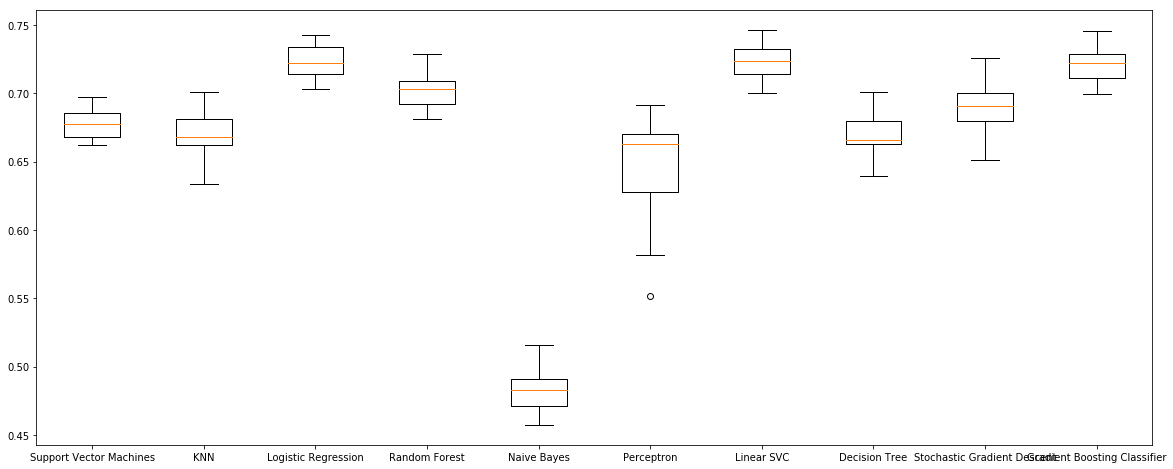

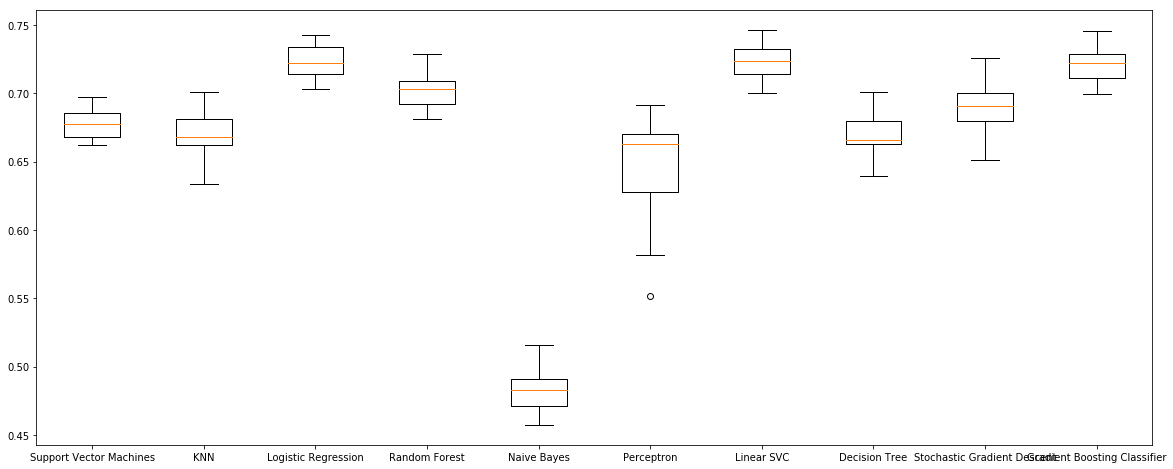

In [43]:
print('Boxplots of the accuracy score achieved for each of the models')

fig, ax = plt.subplots(figsize = (20,8))
plt.boxplot(accuracy[['Accuracy_' + str(i) for i in range(1,20)]])
ax.set_xticklabels(accuracy.index)
plt.show()

## No mirar a partir de aquÃ­, aun hay que revisarlo.

Confusion Matrix for the first Model 

[[1185  213  117]
 [ 156  186   60]
 [  71   42  166]]


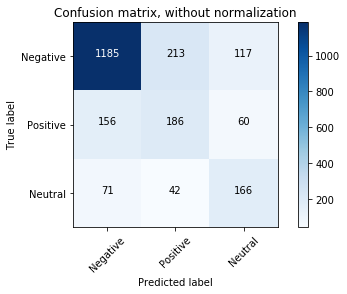

Confusion Matrix for the second model, without outliers 

[[964 113  68]
 [ 70 114  22]
 [ 46  16 150]]


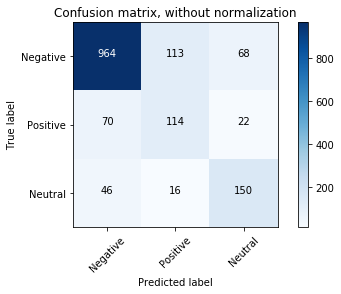

In [157]:
print 'Confusion Matrix for the first Model \n'
cnf_matrix1 = confusion_matrix(pred1, main_dataset['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix2 = confusion_matrix(pred2, aux_dataset['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


Now, we'll create two separate models to see if our predictions are improved in some way. The first model will predict values based on the text of the tweet and the second one, on the airline, the retweet count and the date. But as we cannot feed the pure dates into our ML model, we'll do some feature engineering first:
- Create some useful such us day_of_week, day_of_month, day_of_year
- We have seen that something weird happenned on the 23rd of February of 2015 there was a great amount of people that tweeted with a negative sentiment, so we'll create a bool variable that will indicate wether the tweet has been issued on this day.

Al the things mentioned above will be done in the function: **dealwith_dates**

In [158]:
df = dealwith_dates(df)
dfaux = dealwith_dates(dfaux)
main_df = obtain_data_representation2(df)
aux_df = obtain_data_representation2(dfaux)

/Users/carlos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/carlos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/carlos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Now, let's try the linear **regression model**:

The score achieved by the model trained with the full training data is: 0.580601
---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.671785 

Confusion Matrix for the first Model 

[[1105  251  190]
 [ 184  107   94]
 [ 118   84   63]]


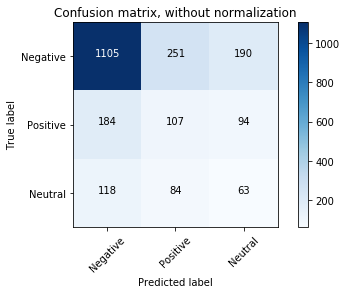

Confusion Matrix for the second model, without outliers 

[[962 143 116]
 [ 74  51  42]
 [ 78  60  37]]


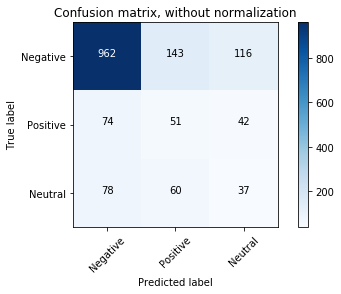

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
main_df['num']['train']['x'] = scaler1.fit_transform(main_df['num']['train']['x'])
main_df['num']['test']['x'] = scaler1.transform(main_df['num']['test']['x'])

aux_df['num']['train']['x'] = scaler2.fit_transform(aux_df['num']['train']['x'])
aux_df['num']['test']['x'] = scaler2.transform(aux_df['num']['test']['x'])

clf_num1 = RandomForestClassifier()
clf_num1.fit(main_df['num']['train']['x'], main_df['num']['train']['y'])
clf_num2 = RandomForestClassifier()
clf_num2.fit(aux_df['num']['train']['x'], aux_df['num']['train']['y'])

pred_num1 = clf_num1.predict(main_df['num']['test']['x'])
pred_num2 = clf_num2.predict(aux_df['num']['test']['x'])
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_df['num']['test']['y'], pred_num1))
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_df['num']['test']['y'], pred_num2)), '\n'


print 'Confusion Matrix for the first Model \n'
cnf_matrix_num1 = confusion_matrix(pred_num1, main_df['num']['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_num1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix_num2 = confusion_matrix(pred_num2, aux_df['num']['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_num2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


In [169]:
main_df['num']['train']['x']

array([[ 0.  ,  0.17,  0.  ,  0.  ,  0.08,  0.2 ],
       [ 0.14,  0.33,  0.14,  0.  ,  0.43,  0.6 ],
       [ 0.86,  0.  ,  0.86,  0.  ,  0.36,  0.  ],
       ..., 
       [ 0.71,  1.  ,  0.71,  0.  ,  0.45,  0.8 ],
       [ 0.71,  1.  ,  0.71,  0.  ,  0.8 ,  0.2 ],
       [ 0.71,  1.  ,  0.71,  0.  ,  0.8 ,  0.8 ]])

##### XGBOOST

The xgboost model will be used in the first place to create a first prediction. Two models will be created that will use (in the first place) the same parameters, to see whether it is better to train the model with the corrected data, or with the full dataset

In [25]:
xgb_params = {
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 1
}

In [26]:
gbm1 = xgb.XGBClassifier()
gbm2 = xgb.XGBClassifier()
# gbm.fit(dataset['train']['x'], dataset['train']['y'],eval_set=[(dataset['train']['x'], dataset['train']['y']), (dataset['test']['x'], dataset['test']['y'])], eval_metric='logloss', verbose=True)

gbm1.fit(main_dataset['train']['x'], main_dataset['train']['y'])
gbm2.fit(aux_dataset['train']['x'], aux_dataset['train']['y'])

pred1 = gbm1.predict(main_dataset['test']['x'])
pred2 = gbm2.predict(aux_dataset['test']['x'])

In [27]:
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_dataset['test']['y'], pred1)), '\n'
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_dataset['test']['y'], pred2)), '\n'


The score achieved by the model trained with the full training data is: 0.739071 

---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.808061 



### Tuning the parameters

In [8]:
'''from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 

xgb_model = XGBClassifier(other_params)

test_params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(train,target)
print model.best_params_'''

"from xgboost.sklearn import XGBClassifier\nfrom sklearn.grid_search import GridSearchCV \n\nxgb_model = XGBClassifier(other_params)\n\ntest_params = {\n 'max_depth':[4,8,12]\n}\n\nmodel = GridSearchCV(estimator = xgb_model,param_grid = test_params)\nmodel.fit(train,target)\nprint model.best_params_"

## Get output

In [82]:
import datetime

def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

    
# Read submission and retrain with whole data
df_submission = pd.read_csv('tweets_submission.csv', index_col='tweet_id')
# We use df_submision as test, otherwise it would split df in train/test
submission_dataset = obtain_data_representation(df, df_submission)

print 'The shape of the testing dataset is: (%i, %i)' % (df_submission.shape), '\n'

print submission_dataset
predictions = clf.predict(submission_dataset['test']['x'])
# Create submission file with obtained y_pred
create_submit_file(df_submission, predictions)

KeyError: 'negativereason'

In [83]:
df_submission

airline             name  retweet_count  \
tweet_id                                                             
569716594731044865          United      TheJonesest              0   
569337064484962304      US Airways       daroberts1              0   
569651366018166784        American          LIGal19              0   
569691772000931840        American     sierrasalles              0   
569525641759993856           Delta        SMHillman              0   
569962709057298432      US Airways     ShawnHFoster              0   
570256553502068736  Virgin America      ayeevickiee              0   
569280669593038848          United       MaxAbrahms              1   
570235609933078529      US Airways    oliviahaymond              0   
569917442455175168        American   politicalpizza              0   
570050603851710464           Delta      kbosspotter              0   
569968023592943616           Delta   DavidAlfieWard              0   
569684137755459584       Southwest  SharkNamedBruce              0   
568473140654788609          United        souleyoga              0   
568468409471492096          United    canmoregolfer              0   
569134718396051456       Southwest    allie_kaji621              0   
569977887136342016        American     FunNateofPMG              0   
570007457055055873       Southwest          mkaynee              0   
569201109400555520          United       darcqhorse              0   
569318130356502528  Virgin America      miaerolinea              0   
569345076406693888      US Airways       sherylfish              0   
568469645843279872      US Airways   cahillwilliamr              0   
569601094239825920        American      EricRoberts              1   
569518200410546176      US Airways      VikingJim60              0   
569358195862462464       Southwest         Firmadge              0   
568841635049533440      US Airways      ConnorCrown              0   
570264011574415360        American       dfwairport              1   
569476889313562624          United     docambrose97              0   
569541591586643968          United      WayneMAaron              2   
569675861160386560       Southwest       wdmichael3              0   
...                            ...              ...            ...   
569223781593403392       Southwest      dillidalley              0   
567765457731624960       Southwest      jwgonsalves              0   
567861975419457537          United   JackieFerrari3              0   
568562512284659713          United         nivekt13              1   
569116333998256129      US Airways     iansilverman              0   
569644634386911232           Delta      GinaMarie_F              0   
568517386795507712      US Airways       relaxed137              0   
570241221303468032        American  ShpprMktMichael              0   
569507834930442241          United        ljsbrooks              0   
568899587424931840          United      ibrowning85              1   
570108724636831745          United        kbleggett              0   
569516908195815425           Delta      djkeating13              0   
569660363794468864        American     agoldenbrown              0   
568889677094232064       Southwest      oliviaxfaye              1   
567848374113693697          United       dwjones712              0   
568382196081229824      US Airways        kim_blake              0   
569504928810414080      US Airways      Katycarlson              0   
570248162067107840        American         dwjudson              0   
567752048402104320       Southwest       dallendoug              0   
570041988986347521          United          MommyPR              0   
568052677881565185          United    WestlakeSarah              0   
569977223198822400       Southwest          seezulu              0   
569992753649729536           Delta        DatingRev              0   
568273152456810496           Delta        aclaessen              0   
568658885361438720       Southwest   